### Tutorial: Use auto ML to predict median housing prices

In this tutorial we will use automated machine learning using prevision auto ml api to create a regression model to predict median housing prices. it includes the following tasks:
* Get, transform an register prevision Datasets
* Launch an automated machine learning use case to perform the regression prediction task
* Get model evaluations and many other utilities offered by Prevision API

#### 1. Set-ups and Imports:

Import the necessary packages and initialize client instance by ginving the URL instance and the corresponding API KEY

In [3]:
import os
import sys
path_elements = os.getcwd().split('/')
sys.path.append(os.sep.join(path_elements[:-1]))
from previsionio.utils import PrevisionException
import previsionio as pio
import pandas as pd


URL = 'https://dev.prevision.io'


# initialize client workspace
pio.prevision_client.client.init_client(URL, TOKEN)
ucs = pio.Supervised.list()
print(ucs)
# define the name of our use case
uc_name = 'housing_from_sdk'


KeyError: 'items'

In [27]:
#delete the use case if it already exists
ucs = pio.Supervised.list()
for uc in ucs:
    if uc['name']==uc_name:
        uc = pio.Supervised.from_name(uc_name)
        uc.delete()

#### Download datasets:
we will get training and holdout dataset by name as follows:


In [28]:

# get train & test dataset stocked on the datastore
train = pio.dataset.Dataset.get_by_name(dataset_name='regression_house_80')
test = pio.dataset.Dataset.get_by_name(dataset_name='regression_house_20')

In [29]:
#the previous function return Dataset objects
print(train)
print(test)

#### Data Exploration:
Explore and apply some transformations


to retieve the pandas dataframe form of the previous datasets, the SDK provides the method **to_pandas** 

In [30]:
train = train.to_pandas()
test = test.to_pandas()

train.head()

,ID,date,TARGET,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,6414100192,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,5631500400,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2487200875,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,1954400510,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,7237550310,20140512,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


#### Some data explorations:

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17351 entries, 0 to 17350
Data columns (total 21 columns):
ID               17351 non-null int64
date             17351 non-null int64
TARGET           17351 non-null float64
bedrooms         17351 non-null int64
bathrooms        17351 non-null float64
sqft_living      17351 non-null int64
sqft_lot         17351 non-null int64
floors           17351 non-null float64
waterfront       17351 non-null int64
view             17351 non-null int64
condition        17351 non-null int64
grade            17351 non-null int64
sqft_above       17351 non-null int64
sqft_basement    17351 non-null int64
yr_built         17351 non-null int64
yr_renovated     17351 non-null int64
zipcode          17351 non-null int64
lat              17351 non-null float64
long             17351 non-null float64
sqft_living15    17351 non-null int64
sqft_lot15       17351 non-null int64
dtypes: float64(5), int64(16)
memory usage: 2.8 MB


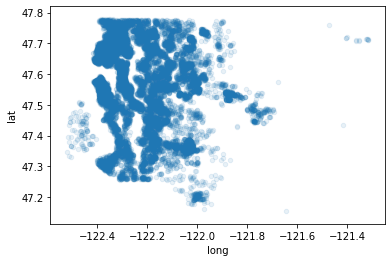

In [32]:
train.plot(kind="scatter", x="long", y="lat", alpha=0.1)

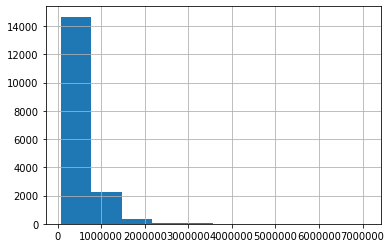

In [33]:
train['TARGET'].hist()

In [34]:
#apply some transformation
#transform a var
for var in ['bathrooms', 'floors']:
    train[var] = train[var].apply(lambda x: round(x)).astype('int')
    test[var] = test[var].apply(lambda x: round(x)).astype('int')

Now register in Previon plateform transformed datasets

In [35]:
#register modified datasets
train_fe = pio.Dataset.new('housing_train', dataframe=train)
test_fe = pio.Dataset.new('housing_test', dataframe=test)
print(train_fe)
print(test_fe)

### Prevision Auto Machine learning with SDk:

To launch automatically a training use case, which consists of creating and evaluating automatically different type of models, we procede as follows:
1. Set the columns configurations required to define at least the target column (see ColumnConfig documentation) 
2. Define the use case settings such as the type of models you want to experiment, the feature engineering to apply (to get more information about the different feature engineering operations provided by our plateform you can consult the Feature class documentation)
3. fit the regression (or classification .. according to the task) by specifiying the training dataset, the holdout (optionally), the corresponding metric and the attached pervios config

It would launch a process that sweeps several machine learning algorithms with different hyperparameters settings according to the pre defined settings. 

=> The auto ml plateform can find the the best model, (or the fastest) by minimizing the given accuracy metric.

In [37]:
## auto ml use case starting
# config use case profile
uc_config = pio.TrainingConfig(models=[pio.Model.XGBoost, pio.Model.RandomForest],
                               features=pio.Feature.Full.drop(pio.Feature.PCA, 
                                                              pio.Feature.KMeans
                                                              ),
                                profile=pio.Profile.Quick,
                                with_blend=False)

#configure columns of datasets
col_config = pio.ColumnConfig(target_column='TARGET', id_column='ID')

#launch Regression auto ml use case
uc = pio.Regression.fit(uc_name,
                        dataset=train_fe,
                        metric=pio.metrics.Regression.RMSE,
                        holdout_dataset=test_fe,
                        column_config=col_config,
                        training_config=uc_config)


In [28]:

uc.wait_until(lambda u: len(u) > 1)

### List the created models:
our  SDK provides utilisties to retrieve all the created models for the current use case a(and also we can filter models by name)

In [32]:
#list all created models
uc.list_models()

[{'upperDeviation': 134568.45672058812,
  '_id': '5e1c66584973c99c7a849d2a',
  'name': 'XGB-1',
  'loss': 122855.59667787825,
  'durationUnitPrevision': 0.25443577766418457,
  'lastUpdate': '2020-01-13T12:45:12.624Z',
  'algorithm': 'XGB',
  'endDate': '2020-01-13T12:45:12.469Z',
  'score': 122456.22639199719,
  'duration': 35.47401714324951,
  'startDate': '2020-01-13T12:44:33.243Z',
  'status': 'done',
  'errorLog': None,
  'lowerDeviation': 110343.99606340626,
  'meanScore': 122456.22639199719,
  'sdScore': 12112.230328590922,
  'tags': {'simple': False,
   'linear': False,
   'best': False,
   'fastest': False,
   'recommended': False},
  'index': 1},
 {'upperDeviation': 127981.52300928993,
  '_id': '5e1c661cd2985ae2508a7023',
  'name': 'XGB-2',
  'loss': 120392.99363855782,
  'durationUnitPrevision': 0.24945306777954102,
  'lastUpdate': '2020-01-13T12:44:12.549Z',
  'algorithm': 'XGB',
  'endDate': '2020-01-13T12:44:12.372Z',
  'score': 120225.92293934974,
  'duration': 24.2304179

In [33]:
#filter by name : list models XGB
uc.list_models(name='xgb')

[{'upperDeviation': 134568.45672058812,
  '_id': '5e1c66584973c99c7a849d2a',
  'name': 'XGB-1',
  'loss': 122855.59667787825,
  'durationUnitPrevision': 0.25443577766418457,
  'lastUpdate': '2020-01-13T12:45:12.624Z',
  'algorithm': 'XGB',
  'endDate': '2020-01-13T12:45:12.469Z',
  'score': 122456.22639199719,
  'duration': 35.47401714324951,
  'startDate': '2020-01-13T12:44:33.243Z',
  'status': 'done',
  'errorLog': None,
  'lowerDeviation': 110343.99606340626,
  'meanScore': 122456.22639199719,
  'sdScore': 12112.230328590922,
  'tags': {'simple': False,
   'linear': False,
   'best': False,
   'fastest': False,
   'recommended': False},
  'index': 1},
 {'upperDeviation': 127981.52300928993,
  '_id': '5e1c661cd2985ae2508a7023',
  'name': 'XGB-2',
  'loss': 120392.99363855782,
  'durationUnitPrevision': 0.24945306777954102,
  'lastUpdate': '2020-01-13T12:44:12.549Z',
  'algorithm': 'XGB',
  'endDate': '2020-01-13T12:44:12.372Z',
  'score': 120225.92293934974,
  'duration': 24.2304179

### Get some Use case derived informations:

We can retrieve same useful informations (which are native opertaions done by the plateform after launching the use case)

#### a. Correlation matrix:

we can get the correlation matrix relative to the vars that contitute the training dataset

In [49]:
## Get some Use case derived informations:
# correlation matrix
print('*************************************')
print('***         GET CORR MATRIX       ***')
print('*************************************')
print()
CM = uc.get_correlation_matrix()
for item in CM:
    print(item)
    print()

*************************************
***         GET CORR MATRIX       ***
*************************************

{'name': 'grade', 'index': 9, 'correlation': [{'name': 'grade', 'score': 1}, {'name': 'sqft_living15', 'score': 0.709199442851357}, {'name': 'bathrooms', 'score': 0.5880252786537089}, {'name': 'sqft_living', 'score': 0.7613559319140909}, {'name': 'sqft_above', 'score': 0.741046702026659}, {'name': 'TARGET', 'score': 0.6568064864739641}]}

{'name': 'sqft_living15', 'index': 8, 'correlation': [{'name': 'grade', 'score': 0.709199442851357}, {'name': 'sqft_living15', 'score': 1}, {'name': 'bathrooms', 'score': 0.498392893801939}, {'name': 'sqft_living', 'score': 0.7565628165933507}, {'name': 'sqft_above', 'score': 0.7211605689461829}, {'name': 'TARGET', 'score': 0.6018140820155015}]}

{'name': 'bathrooms', 'index': 6, 'correlation': [{'name': 'grade', 'score': 0.5880252786537089}, {'name': 'sqft_living15', 'score': 0.498392893801939}, {'name': 'bathrooms', 'score': 1}, {'name'

#### b. Feature stats:

Prevsion SDK provides also a function to get some basic stistics (such as ) ralted to the features that constitute the training dataset

In [38]:
# basic feauture stats

print('*************************************')
print('***    GET FEATURE STATISTICS    ***')
print('*************************************')
FS = uc.get_feature_stats()
for item in FS:
    print()
    print(item)
    

*************************************
***    GET FEATURE STATISTICS    ***
*************************************

message

code

status


#### c. one Feature infos:

if we want to get more detailed informations about one specefic feature, Prevsion SDK includes the corresponding function

In [53]:
# one specefic feature infos
print('*************************************')
print('***    GET FEATURE STATISTICS    ***')
print('*************************************')
FI = uc.get_feature_info(feature_name='bathrooms')
print(FI)

*************************************
***    GET FEATURE STATISTICS    ***
*************************************
{'importanceValue': {'usedInBestModel': False, 'oftenImportant': False, 'importantInTop3Model': False, 'previsionImportanceEstimation': 0}, 'featureBivariateChart': {'chart': {'type': 'candlestick'}, 'series': [{'x': '0.000 - 1.000', 'y': [162500, 200000, 357500, 398750]}, {'x': '1.000 - 2.000', 'y': [210937.5, 260625, 490000, 555000]}, {'x': '2.000 - 9.000', 'y': [296922.5, 375000, 749950, 859347.5]}]}, 'stats': {'missingValues': 0, 'missingValuesPart': 0, 'countValues': 17351, 'min': 0, 'max': 8, 'mean': 1.747103913319117, 'std': 0.7357597955527552, 'median': 2}, 'chartData': {'chart': {'type': 'bar'}, 'series': [{'name': 'histogram', 'data': [0.41, 38.93, 48.45, 10.32, 0, 1.61, 0.2, 0.06, 0.01, 0.01]}], 'xaxis': {'categories': ['0.00 - 0.800', '0.800 - 1.60', '1.60 - 2.40', '2.40 - 3.20', '3.20 - 4.00', '4.00 - 4.80', '4.80 - 5.60', '5.60 - 6.40', '6.40 - 7.20', '7.20 - 8

### Retrieve some typical models:
#### a- The best model:

one of the modt important operations offered by our solution is that it can find out the best model of the use case that you have launched (with the configurations that you had set) : the best model is the one which has the best performances (in other words having the minimal value of the chosen erro metric)

In [54]:
## Get some typical models 
# a- the model with the best performances (having the minimal value of the chosen erro metric)
print('*************************************')
print('***         GET BEST MODEL        ***')
best_model = uc.get_best_model()
print(best_model.__dict__)

*************************************
***         GET BEST MODEL        ***
{'_id': None, 'event_manager': None, 'uc_id': '5e1c65ab5001b1001efe548f', 'is_best': True, 'name': 'XGB-9', 'upperDeviation': 0, 'loss': 1, 'durationUnitPrevision': None, 'lastUpdate': '2020-01-13T12:42:37.422Z', 'algorithm': 'XGB', 'endDate': None, 'trialId': None, 'score': False, 'duration': None, 'featureSelection': None, 'startDate': None, 'status': 'running', 'errorLog': None, 'lowerDeviation': 0, 'meanScore': None, 'sdScore': None, 'tags': {'simple': False, 'linear': False, 'best': False, 'fastest': False, 'recommended': False}, 'index': 9, 'prediction_event_manager': <previsionio.prevision_client.EventManager object at 0x7f4c10419240>}


#### b- The fastest model:

We also can retrieve the model that predicts with the lowest response time

In [55]:
# b- the fastest model (having the minimal prediction time)
print('************************************')
print('***       GET FASTEST MODEL      ***')
fastest_model = uc.get_fastest_model()
print(fastest_model.__dict__)

************************************
***       GET FASTEST MODEL      ***
{'_id': '5e1c662c5527354235087f74', 'event_manager': None, 'uc_id': '5e1c65ab5001b1001efe548f', 'is_best': False, 'name': 'RF-6', 'upperDeviation': 147416.76177442278, 'loss': 133151.26375909627, 'durationUnitPrevision': 0.14809322357177734, 'lastUpdate': '2020-01-13T12:44:28.909Z', 'algorithm': 'RF', 'endDate': '2020-01-13T12:44:28.729Z', 'score': 132599.7630665592, 'duration': 85.97841119766235, 'startDate': '2020-01-13T12:42:44.434Z', 'status': 'done', 'errorLog': None, 'lowerDeviation': 117782.76435869561, 'meanScore': 132599.7630665592, 'sdScore': 14816.99870786358, 'tags': {'simple': False, 'linear': False, 'best': False, 'fastest': True, 'recommended': False}, 'index': 6, 'prediction_event_manager': <previsionio.prevision_client.EventManager object at 0x7f4c10346898>}


#### C- a specefic model:

and we can also get a specefic one (not especially the fastest or the best) by giving its name

In [56]:
# c- a specefic model (if a specefic model is desired, the SDK gives utilies to deal with it)
print('************************************')
print('***     GET A SPECEFIC MODEL     ***')   
specefic_model = uc.get_model_from_name('XGB-1')
print(specefic_model.__dict__)


************************************
***     GET A SPECEFIC MODEL     ***
{'_id': '5e1c66584973c99c7a849d2a', 'event_manager': None, 'uc_id': '5e1c65ab5001b1001efe548f', 'is_best': False, 'name': 'XGB-1', 'upperDeviation': 134568.45672058812, 'loss': 122855.59667787825, 'durationUnitPrevision': 0.25443577766418457, 'lastUpdate': '2020-01-13T12:45:12.624Z', 'algorithm': 'XGB', 'endDate': '2020-01-13T12:45:12.469Z', 'score': 122456.22639199719, 'duration': 35.47401714324951, 'startDate': '2020-01-13T12:44:33.243Z', 'status': 'done', 'errorLog': None, 'lowerDeviation': 110343.99606340626, 'meanScore': 122456.22639199719, 'sdScore': 12112.230328590922, 'tags': {'simple': False, 'linear': False, 'best': False, 'fastest': False, 'recommended': False}, 'index': 1, 'prediction_event_manager': <previsionio.prevision_client.EventManager object at 0x7f4c0341da20>}


#### PREDICTION:

We can use the chosen model to make prediction with different ways:
* 1. we can apply predection by giving a dataframe with the samples tha we want to prediction
* 2. apply the model to a test dataset that is alredy registed in our datastore
* 3. get Cross Validation predictions
* 4. predict for a sigle data input

In [68]:
#1 - prediction for a new dataframe sample
df = test_fe.to_pandas().sample(frac=0.2, replace=True, random_state=42)
print('***************************************')
print('*** GET PREDICTIONS of an input dataframe ***')
print('***************************************')
df_preds = best_model.predict(df)
print(df_preds.head())

***************************************
*** GET PREDICTIONS of an input dataframe ***
***************************************
5e1c70295001b1001efe54a4
           ID        TARGET
0  8113100850  4.040955e+05
1  3288301010  4.663820e+05
2  4326000190  4.295602e+05
3  4389200796  1.444821e+06
4  1245003660  6.820428e+05


In [69]:
df_preds

,ID,TARGET
0,8113100850,4.040955e+05
1,3288301010,4.663820e+05
2,4326000190,4.295602e+05
3,4389200796,1.444821e+06
4,1245003660,6.820428e+05
...,...,...
847,3319500628,3.814506e+05
848,4123840210,3.347928e+05
849,7635801321,4.682230e+05
850,8651402910,1.889481e+05


In [72]:
#2- predict from a registred dataset name
print('*******************************************')
print('*** GET PREDICTIONS of registred dataset ***')
dataset_preds = best_model.predict_from_dataset_name(dataset_name='regression_house_20_fe')


*******************************************
*** GET PREDICTIONS of registred dataset ***


In [73]:
# 3 - Get the Cross validation predictions
print('*******************************************')
print('***        GET CROSS VALIDATION        ***')
print('*******************************************')
cv = fastest_model.get_cv()
print(cv.head())

*******************************************
***        GET CROSS VALIDATION        ***
*******************************************
           ID     TARGET   pred_TARGET  __fold__
0  6414100192   538000.0  4.829632e+05         2
1  5631500400   180000.0  2.866701e+05         3
2  2487200875   604000.0  4.422417e+05         3
3  1954400510   510000.0  5.032323e+05         1
4  7237550310  1225000.0  1.277430e+06         3


In [75]:
# 4- unit prediction
print('*******************************************')
print('***        ONE UNIT PREDICTION         ***')
print('*******************************************')
unit = df.iloc[7]
print("single unit :", unit)
print('*******************************************')
print("prediction : ", specefic_model.predict_single(unit))

*******************************************
***        ONE UNIT PREDICTION         ***
*******************************************
single unit : Unnamed: 0       1.300000e+02
ID               3.013300e+09
date             2.014093e+07
TARGET           4.785000e+05
bedrooms         3.000000e+00
bathrooms        1.000000e+00
sqft_living      2.090000e+03
sqft_lot         4.755000e+03
floors           1.000000e+00
waterfront       0.000000e+00
view             2.000000e+00
condition        3.000000e+00
grade            8.000000e+00
sqft_above       1.200000e+03
sqft_basement    8.900000e+02
yr_built         1.969000e+03
yr_renovated     0.000000e+00
zipcode          9.813600e+04
lat              4.753040e+01
long            -1.223870e+02
sqft_living15    1.850000e+03
sqft_lot15       5.300000e+03
Name: 130, dtype: float64
*******************************************
prediction :  {'ID': 0, 'TARGET': 1087511.5}
